In [1]:
import os
import torch
import sys
import random
import matplotlib.pyplot as plt
import dancher_tools_segmentation as dt
import torchvision.transforms as T
import numpy as np

module_path = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(module_path)

def evaluate_model(test_loader, model, device):
    """
    对测试集进行评估，计算 mIoU、precision、recall 和 f1_score。
    """
    model.eval()
    metrics = {
        "mIoU": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }
    criterion = model.criterion  # 使用模型绑定的损失函数
    total_loss = 0.0

    with torch.no_grad():
        for images, masks, _ in test_loader:
            images, masks = images.to(device), masks.to(device)

            # 模型预测
            logits = model(images)
            preds = torch.argmax(logits, dim=1)

            # 计算损失
            loss = criterion(logits, masks)
            total_loss += loss.item()

            # 计算每个指标
            for metric_name, metric_fn in model.metrics.items():
                metric_value = metric_fn(preds, masks, model.num_classes)
                metrics[metric_name].append(metric_value)

    # 计算平均值
    avg_loss = total_loss / len(test_loader)
    avg_metrics = {metric_name: np.mean(values) for metric_name, values in metrics.items()}

    print(f"Test Loss: {avg_loss:.4f}")
    for metric_name, value in avg_metrics.items():
        print(f"{metric_name}: {value:.4f}")

    return avg_loss, avg_metrics

def display_prediction_samples(test_loader, model, device, num_samples=3):
    """
    随机从数据集中选取样本，用模型预测并展示原图、真实掩码和预测结果。
    """
    model.eval()
    samples = torch.utils.data.Subset(test_loader.dataset, random.sample(range(len(test_loader.dataset)), num_samples))

    # 定义反归一化
    unnormalize = T.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                               std=[1 / 0.229, 1 / 0.224, 1 / 0.225])

    with torch.no_grad():
        for image, mask in samples:
            print(f"[DEBUG] Raw image shape: {image.shape}, dtype: {image.dtype}")
            print(f"[DEBUG] Raw mask shape: {mask.shape}, dtype: {mask.dtype}")

            # 移动数据到设备
            image, mask = image.to(device), mask.to(device)

            # 模型预测
            logits = model(image.unsqueeze(0))  # 添加批次维度
            pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

            # 检查 mask 是否为多通道格式
            if mask.ndim > 2 and mask.shape[0] > 1:
                mask = torch.argmax(mask, dim=0)  # 假设掩码为 one-hot 编码
            mask_np = mask.squeeze().cpu().numpy()

            # 检查 `mask_np` 的维度
            if mask_np.ndim != 2:
                raise ValueError(f"Mask shape invalid: {mask_np.shape}, expected (H, W).")

            # 反归一化图像
            image_np = unnormalize(image).permute(1, 2, 0).cpu().numpy()
            print(f"[DEBUG] Image after unnormalize: shape={image_np.shape}, range=({image_np.min()}, {image_np.max()})")

            # 确保图像范围在 [0, 1]
            image_np = np.clip(image_np, 0, 1)

            # 绘制图像、真实掩码和预测掩码
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(image_np)
            axes[0].set_title("Original Image")
            axes[0].axis("off")

            axes[1].imshow(mask_np, cmap="gray")
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis("off")

            axes[2].imshow(pred_mask, cmap="gray")
            axes[2].set_title("Predicted Mask")
            axes[2].axis("off")

            plt.show()


Successfully loaded dataset module: IWFullSceneDataset
Successfully loaded color maps and class names for dataset 'IWFullSceneDataset'
Loaded and validated config from configs/Full/S1/TWIC-Net.yaml: {'model_name': 'FLaTO', 'img_size': 224, 'num_classes': 2, 'weights': None, 'transfer_weights': None, 'load_mode': 'best', 'learning_rate': 0.001, 'batch_size': 16, 'num_workers': 4, 'patience': 50, 'delta': 0.005, 'loss': 'ce', 'loss_weights': None, 'num_epochs': 500, 'model_save_dir': './results/Full/S1/TWIC-Net', 'metrics': ['mIoU', 'precision', 'recall', 'f1_score'], 'export': False, 'conf_threshold': None, 'save_interval': 5, 'in_channels': 3, 'ds': {'name': 'IWFullSceneDataset', 'train_paths': ['datasets/S1_split/train', 'datasets/S1_split/test'], 'test_paths': ['datasets/S1_split/test'], 'color_to_class': {(0, 0, 0): 0, (255, 255, 255): 1}, 'class_to_color': {0: (0, 0, 0), 1: (255, 255, 255)}, 'class_name': ['background', 'internal wave']}}
Successfully loaded dataset module: IWFullS

Processing images in datasets/S1_split/test: 100%|██████████| 3/3 [00:17<00:00,  5.68s/it]


[DEBUG] No MD5 found in cache: datasets/S1_split/test/__cache__.h5


Processing images in datasets/S1_split/test: 100%|██████████| 3/3 [00:17<00:00,  5.77s/it]
/home/dancher/anaconda3/envs/iw_seg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded custom model 'FLaTO' from 'models/FLaTO.py'.
n_patches: 196, img_size: 14, patch_size: 1
Model successfully loaded from ./results/Full/S1/TWIC-Net/FLaTO_best.pth, epoch: 46, best_val: 0.948167622089386.
Model compiled with metrics: ['mIoU', 'precision', 'recall', 'f1_score']
Displaying model predictions on test samples...
[DEBUG] Raw image shape: torch.Size([3, 224, 224]), dtype: torch.float32
[DEBUG] Raw mask shape: torch.Size([224, 224]), dtype: torch.int64
[DEBUG] Image after unnormalize: shape=(224, 224, 3), range=(0.007843127474188805, 1.0)


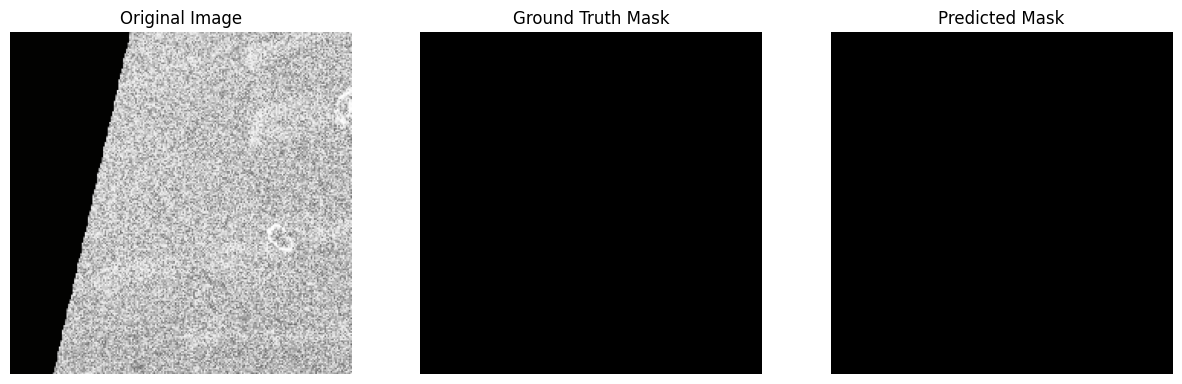

[DEBUG] Raw image shape: torch.Size([3, 224, 224]), dtype: torch.float32
[DEBUG] Raw mask shape: torch.Size([224, 224]), dtype: torch.int64
[DEBUG] Image after unnormalize: shape=(224, 224, 3), range=(0.2549019455909729, 0.9960784316062927)


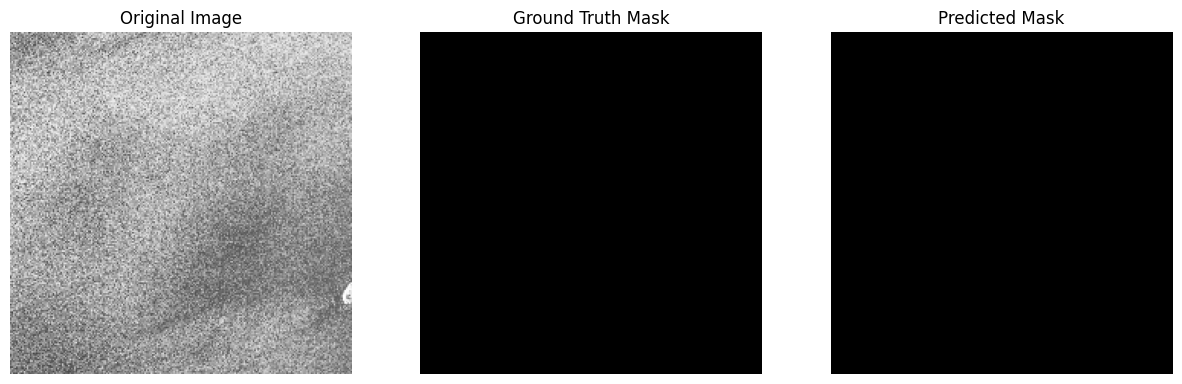

[DEBUG] Raw image shape: torch.Size([3, 224, 224]), dtype: torch.float32
[DEBUG] Raw mask shape: torch.Size([224, 224]), dtype: torch.int64
[DEBUG] Image after unnormalize: shape=(224, 224, 3), range=(0.003921545576304197, 0.0039215851575136185)


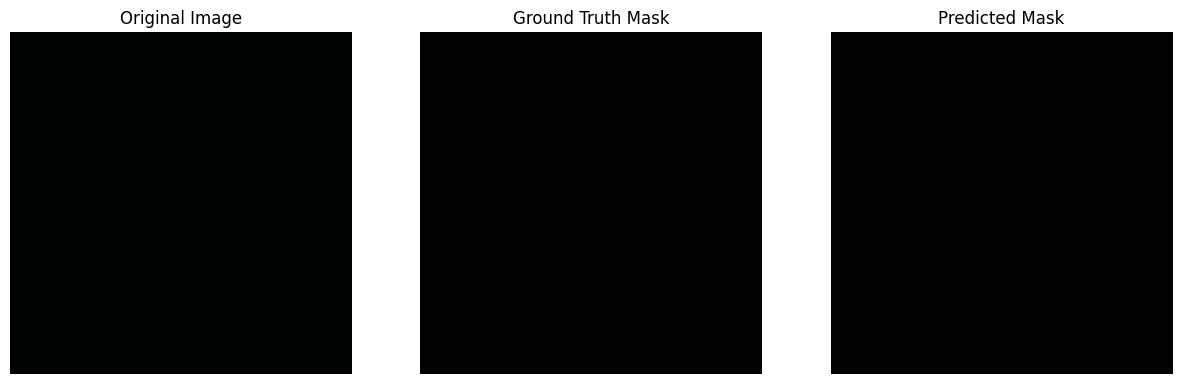

[DEBUG] Raw image shape: torch.Size([3, 224, 224]), dtype: torch.float32
[DEBUG] Raw mask shape: torch.Size([224, 224]), dtype: torch.int64
[DEBUG] Image after unnormalize: shape=(224, 224, 3), range=(0.007843127474188805, 1.0)


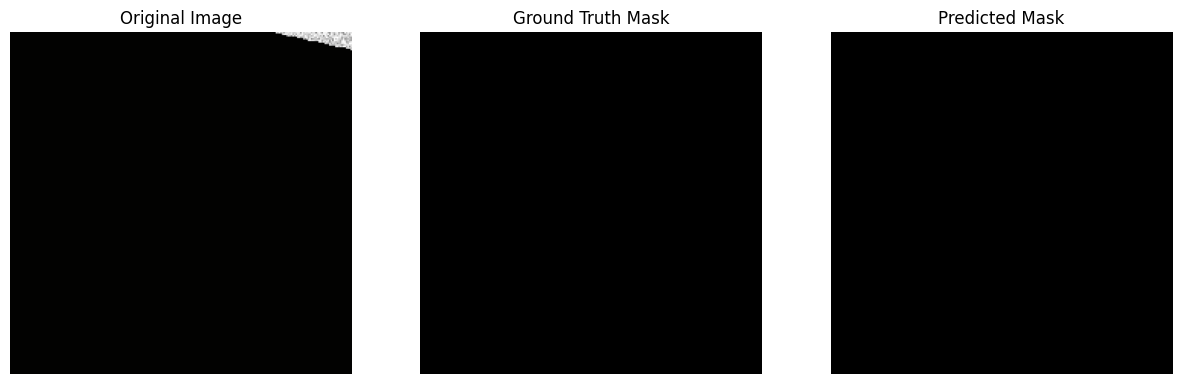

[DEBUG] Raw image shape: torch.Size([3, 224, 224]), dtype: torch.float32
[DEBUG] Raw mask shape: torch.Size([224, 224]), dtype: torch.int64
[DEBUG] Image after unnormalize: shape=(224, 224, 3), range=(0.19607841968536377, 0.9764705896377563)


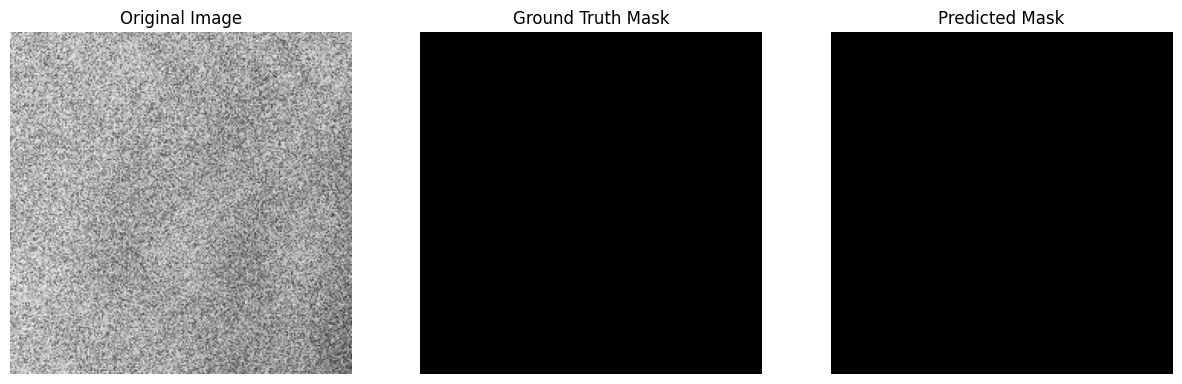

[DEBUG] Raw image shape: torch.Size([3, 224, 224]), dtype: torch.float32
[DEBUG] Raw mask shape: torch.Size([224, 224]), dtype: torch.int64
[DEBUG] Image after unnormalize: shape=(224, 224, 3), range=(0.34509801864624023, 0.9921568036079407)


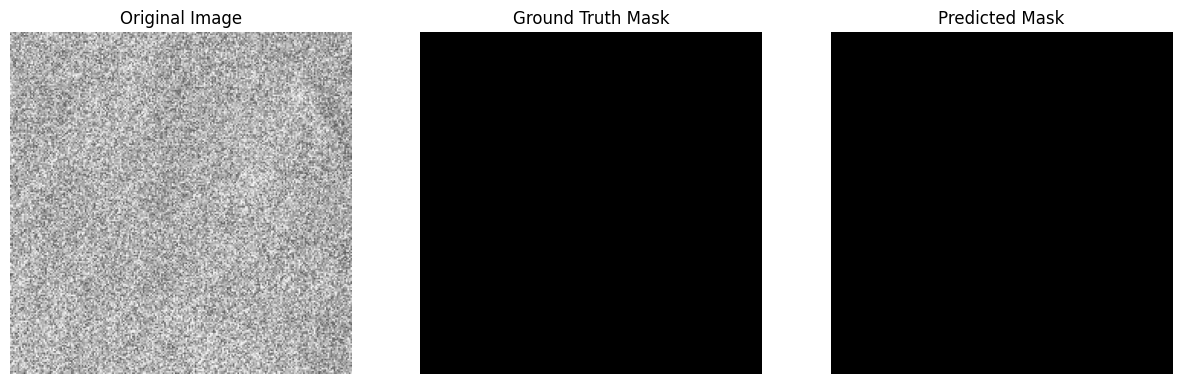

[DEBUG] Raw image shape: torch.Size([3, 224, 224]), dtype: torch.float32
[DEBUG] Raw mask shape: torch.Size([224, 224]), dtype: torch.int64
[DEBUG] Image after unnormalize: shape=(224, 224, 3), range=(0.003921545576304197, 0.0039215851575136185)


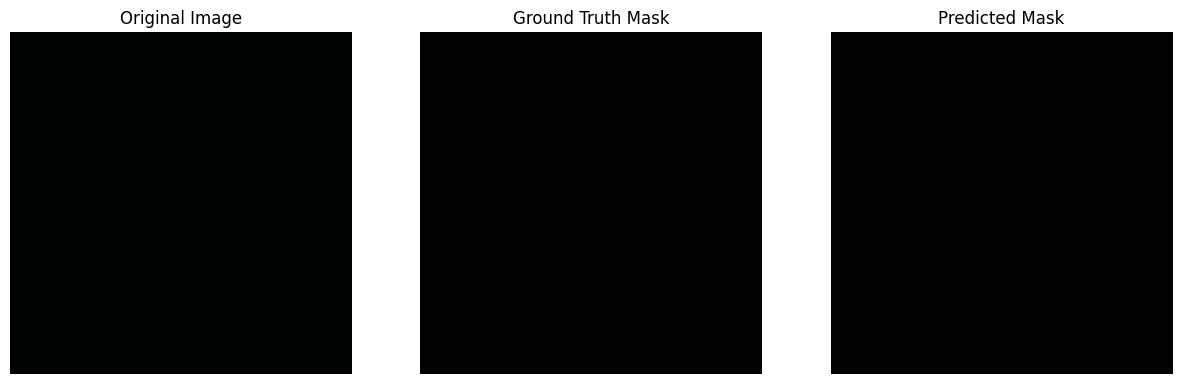

[DEBUG] Raw image shape: torch.Size([3, 224, 224]), dtype: torch.float32
[DEBUG] Raw mask shape: torch.Size([224, 224]), dtype: torch.int64
[DEBUG] Image after unnormalize: shape=(224, 224, 3), range=(0.003921545576304197, 0.0039215851575136185)


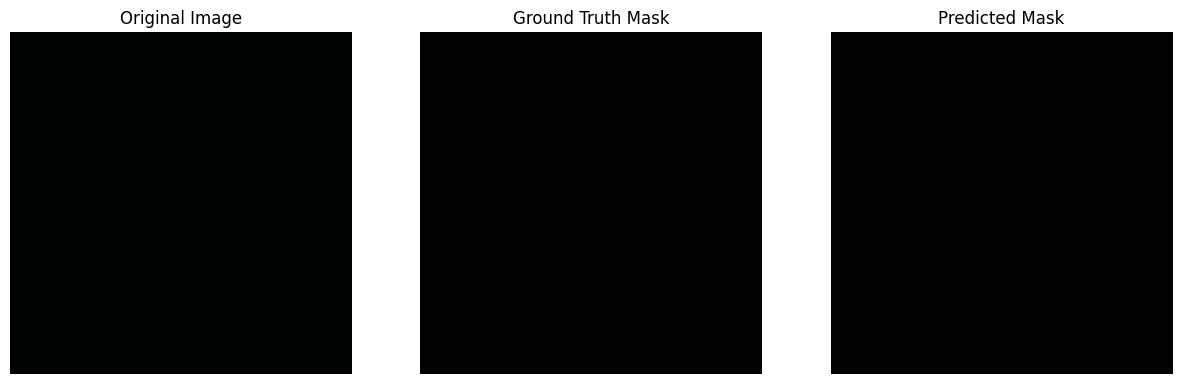

[DEBUG] Raw image shape: torch.Size([3, 224, 224]), dtype: torch.float32
[DEBUG] Raw mask shape: torch.Size([224, 224]), dtype: torch.int64
[DEBUG] Image after unnormalize: shape=(224, 224, 3), range=(0.003921545576304197, 0.007843170315027237)


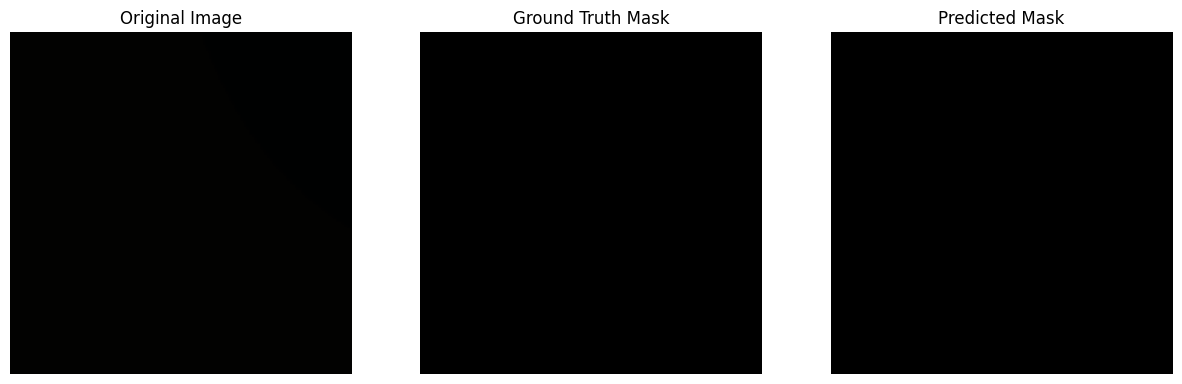

[DEBUG] Raw image shape: torch.Size([3, 224, 224]), dtype: torch.float32
[DEBUG] Raw mask shape: torch.Size([224, 224]), dtype: torch.int64
[DEBUG] Image after unnormalize: shape=(224, 224, 3), range=(0.007843127474188805, 0.007843170315027237)


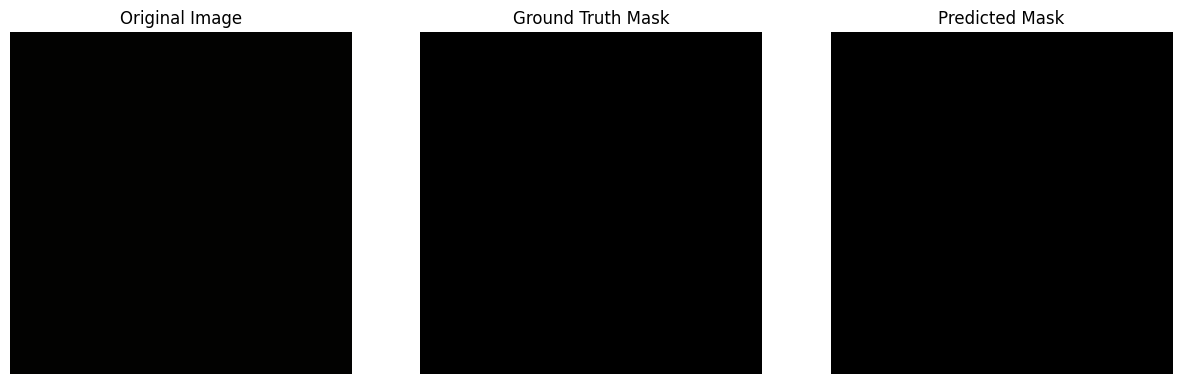

In [2]:
# 解析参数
# args = dt.utils.get_config('configs/Full/UNet.yaml')
# args = dt.utils.get_config('configs/Full/TWIC-Net.yaml')
# args.weight = 'results/FLaTO/GK2A_one/FLaTO_best.pth'
args = dt.utils.get_config('configs/Full/S1/TWIC-Net.yaml')

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 获取数据加载器（测试集）
train_loader, test_loader = dt.utils.get_dataloaders(args)

# 初始化并加载模型
model = dt.utils.get_model(args, device)
model.load(model_dir=args.model_save_dir, mode=args.load_mode, specified_path=args.weights)

# 定义损失函数
criterion = dt.utils.get_loss(args)

# 配置模型
metrics = dt.utils.get_metrics(args)
model.compile(optimizer=None, criterion=criterion, metrics=metrics, loss_weights=args.loss_weights)

# 评估模型
# print("Evaluating model on test set...")
# evaluate_model(test_loader, model, device)

# 展示模型预测结果
print("Displaying model predictions on test samples...")
display_prediction_samples(test_loader, model, device, num_samples=10)


In [3]:
print("Train dataset length:", len(train_loader))


Train dataset length: 203
